### Import Libraries

In [1]:
# Importing required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Load Dataset and Preprocess

In [3]:
# Load the dataset
df = pd.read_csv("student_performance/StudentPerformanceFactorsAdjusted.csv")

In [4]:
# Define score ranges function
def aggregate_classes(score):
    if score >= 55 and score <= 60:
        return "55-60"
    elif score >= 61 and score <= 65:
        return "61-65"
    elif score >= 66 and score <= 70:
        return "66-70"
    elif score >= 71 and score <= 75:
        return "71-75"
    elif score >= 76 and score <= 80:
        return "76-80"
    else:
        return "81+"

In [5]:
# Initialize label encoders for categorical variables
label_encoders = {}
categorical_columns = df.select_dtypes(include='object').columns

In [6]:
# Encode categorical variables
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [7]:
# Handle missing values
df.fillna(df.median(), inplace=True)

In [8]:
# Prepare features and target
X = df.drop('Exam_Score', axis=1)
y = df['Exam_Score'].map(aggregate_classes)

In [9]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Initial Model Training and Evaluation

In [10]:
# Split data and train initial model
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [11]:
# Create and train initial Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [12]:
# Define scorers for evaluation
scorers = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, average='weighted', zero_division=0),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted'),
    'roc_auc': make_scorer(roc_auc_score, average='weighted', multi_class='ovr')
}

In [13]:
# Perform cross-validation
cv_results = cross_validate(rf_model, X_scaled, y, cv=5, scoring=scorers)

In [14]:
# Calculate and display metrics
print("\nRandom Forest Metrics Before Balancing:")
metrics = {
    "Accuracy": (cv_results['test_accuracy'].mean(), cv_results['test_accuracy'].std()),
    "Precision": (cv_results['test_precision'].mean(), cv_results['test_precision'].std()),
    "Recall": (cv_results['test_recall'].mean(), cv_results['test_recall'].std()),
    "F1": (cv_results['test_f1'].mean(), cv_results['test_f1'].std()),
    "AUC": (cv_results['test_roc_auc'].mean(), cv_results['test_roc_auc'].std())
}

for metric, (mean, std) in metrics.items():
    print(f"{metric}: Mean = {mean:.4f}, Std = {std:.4f}")


Random Forest Metrics Before Balancing:
Accuracy: Mean = 0.7958, Std = 0.0068
Precision: Mean = 0.7920, Std = 0.0140
Recall: Mean = 0.7958, Std = 0.0068
F1: Mean = 0.7784, Std = 0.0078
AUC: Mean = nan, Std = nan


In [15]:
# Make predictions and show classification report
y_pred = rf_model.predict(X_test)
print("\nClassification Report Before Balancing:")
print(classification_report(y_test, y_pred))
print(f"\nTest Set Accuracy: {accuracy_score(y_test, y_pred):.4f}")


Classification Report Before Balancing:
              precision    recall  f1-score   support

       55-60       1.00      0.17      0.29        24
       61-65       0.84      0.80      0.82       399
       66-70       0.78      0.92      0.84       667
       71-75       0.89      0.57      0.70       223
       76-80       0.00      0.00      0.00         3
         81+       0.00      0.00      0.00         6

    accuracy                           0.81      1322
   macro avg       0.58      0.41      0.44      1322
weighted avg       0.81      0.81      0.79      1322


Test Set Accuracy: 0.8064


### Apply SMOTE and Hyperparameter Tuning

In [16]:
# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_scaled, y)

In [17]:
# Split balanced data
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

In [18]:
# Define parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

In [19]:
# Perform GridSearchCV
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), 
                          param_grid, 
                          cv=5, 
                          scoring='f1_weighted',
                          n_jobs=4)
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")

Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


### Final Model Evaluation

In [20]:
# Train final model with best parameters
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, n_estimators=200, random_state=42)

In [21]:
# Make predictions
y_pred = best_rf.predict(X_test)

In [22]:
# Calculate and display final metrics
print("\nRandom Forest Metrics After SMOTE and Tuning:")
print(classification_report(y_test, y_pred))
print(f"Test Set Accuracy: {accuracy_score(y_test, y_pred):.4f}")


Random Forest Metrics After SMOTE and Tuning:
              precision    recall  f1-score   support

       55-60       0.99      1.00      0.99       656
       61-65       0.94      0.90      0.92       733
       66-70       0.85      0.89      0.87       635
       71-75       0.96      0.95      0.95       664
       76-80       1.00      1.00      1.00       715
         81+       1.00      1.00      1.00       669

    accuracy                           0.96      4072
   macro avg       0.96      0.96      0.96      4072
weighted avg       0.96      0.96      0.96      4072

Test Set Accuracy: 0.9568


### Feature Importance Visualization

In [23]:
# Get feature importance
importances = best_rf.feature_importances_
feature_names = X.columns

In [24]:
# Sort features by importance
indices = np.argsort(importances)[::-1]

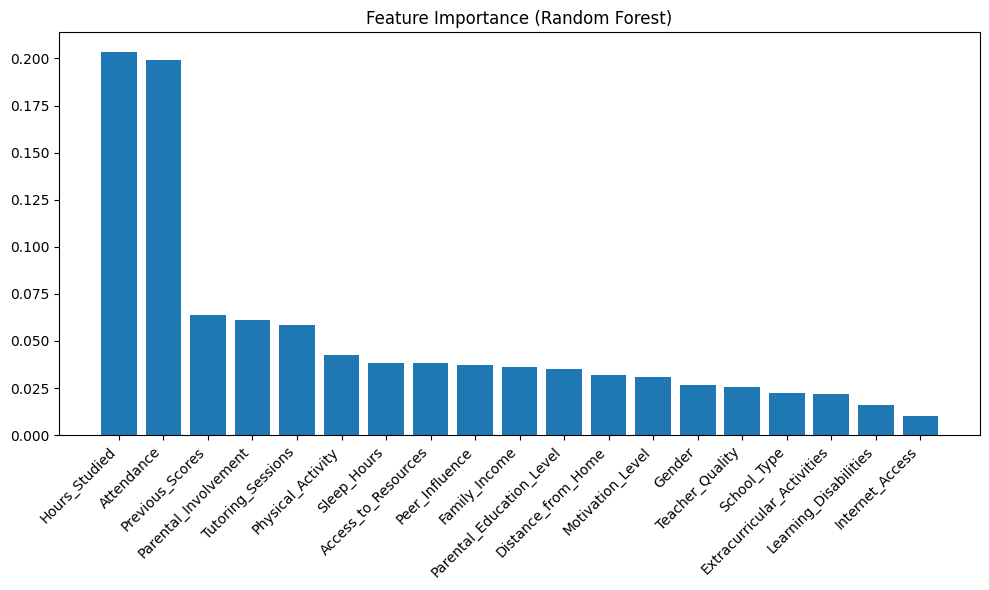

In [25]:
# Plot feature importance
plt.figure(figsize=(10, 6))
plt.title('Feature Importance (Random Forest)')
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=45, ha='right')
plt.tight_layout()
plt.show()